# GCN Hyperparameter Sweep with Optuna + Motif Metrics

This notebook performs systematic hyperparameter optimization for the GCN model using Optuna. Works in both **Google Colab** and **VSCode/Local Jupyter**.

## Setup Instructions

### For Google Colab:
1. **Mount Google Drive** (automatic)
2. **Install Dependencies** (Optuna if not already installed)
3. **Run the Sweep** (20 trials by default, ~1-2 hours)
4. **Train Best Model and Compute Motif Metrics** (~30 minutes)
5. **View Results** (visualizations and metrics)

### For VSCode/Local Jupyter:
1. **Navigate to project directory** before opening notebook
2. **Install Dependencies** (run the pip install cells)
3. **Run the Sweep** (same as Colab)
4. **View Results** (same as Colab)

The notebook automatically detects the environment and adjusts accordingly.

## Step 1: Set Up Paths (Works in both Google Colab and VSCode)

In [1]:
import os
from pathlib import Path

# Detect if running in Google Colab
try:
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # Mount Google Drive (Colab only)
    drive.mount('/content/drive')
    
    # Set working directory to your project
    project_dir = '/content/drive/My Drive/182-GNN_SAE'  # Adjust path if needed
    os.chdir(project_dir)
else:
    # Running locally in VSCode or Jupyter
    # Assume we're already in the project directory or specify the path
    project_dir = os.getcwd()
    
    # Verify we're in the right directory by checking for key files
    expected_files = ['gnn_train_copy.py', 'gnn_train.py']
    missing_files = [f for f in expected_files if not os.path.exists(f)]
    
    if missing_files:
        print(f"⚠ Warning: Expected files not found: {missing_files}")
        print(f"Current directory: {project_dir}")
        print("Please ensure you're running this notebook from the 182-GNN_SAE directory")
    else:
        print("✓ Working directory verified")

print(f"Working directory: {os.getcwd()}")
print(f"\nDirectory contents:")
print(os.listdir('.')[:20])  # Show first 20 items

✓ Working directory verified
Working directory: /data/users/goodarzilab/shervin/182-GNN_SAE

Directory contents:
['run_batch_ablations.py', 'sparse_autoencoder.py', 'sae_activations_motif_new.ipynb', 'hyperparameter_sweep_gcn_colab.ipynb', 'gnn_train.py', 'outputs', 'virtual_graphs', 'README.md', 'graph_generation.md', 'compare_sae_configs.py', 'ABLATION_GUIDE.md', 'interpretability_analysis.py', '.git', 'gnn_train_copy.py', 'run_ablation.py', 'sae_activations_motif.ipynb', '__pycache__', 'analysis_notebook.ipynb', 'checkpoints']


## Step 2: Install Dependencies

In [2]:
# Install required packages
!pip install optuna -q
!pip install torch-geometric -q

print("✓ Dependencies installed successfully")

✓ Dependencies installed successfully


## Step 3: Import Libraries

In [3]:
import json
import os
from pathlib import Path
from typing import List, Tuple
from collections import defaultdict

import numpy as np
import pandas as pd
import optuna
from optuna.trial import Trial
from optuna.samplers import TPESampler
# from optuna.pruners import MedianPruner
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

# Check GPU availability
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

/data/users/goodarzilab/shervin/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU Available: True
GPU Name: NVIDIA TITAN V
GPU Memory: 12.64 GB


## Step 4: Import Functions from gnn_train.py

In [5]:
# Import from gnn_train.py
from gnn_train_copy import (
    _save_split_metadata,
    GraphDataset,
    GCNModel,
    GNNTrainer,
    collate_fn,
    load_all_graphs,
    split_data,
    MOTIF_LABELS,
    MOTIF_TO_ID
)

print("✓ Successfully imported all functions from gnn_train.py")

# ⊘ COMMENTED OUT: Motif-specific metrics analysis (training on mixed motif graphs now)
# Helper function to compute graph-level motif metrics (from benchmarking.py approach)
# def compute_motif_metrics_graphlevel(model, test_loader, device='cuda'):
#     """
#     Compute MSE and MAE metrics per motif type using graph-level aggregation.
#     This ensures each graph contributes equally to the final statistics.
#
#     Args:
#         model: Trained model to evaluate
#         test_loader: DataLoader with test data (can have mixed motifs)
#         device: Device to run on
#
#     Returns:
#         Dict with per-motif metrics: {motif_label: {mean_mse, std_mse, mean_mae, std_mae, num_graphs}}
#     """
#     model.to(device)
#     model.eval()
#     criterion_mse = torch.nn.MSELoss(reduction='none')
#
#     motif_losses = defaultdict(list)
#     motif_counts = defaultdict(int)
#
#     with torch.no_grad():
#         for batch in test_loader:
#             batch = batch.to(device)
#             pred = model(batch)
#
#             # Compute per-node losses
#             loss_per_node_mse = criterion_mse(pred, batch.y)
#
#             # Extract motif information from batch
#             if hasattr(batch, 'batch'):
#                 batch_indices = batch.batch
#             else:
#                 batch_indices = torch.zeros(batch.y.size(0), dtype=torch.long, device=device)
#
#             unique_graphs = torch.unique(batch_indices)
#
#             for g in unique_graphs:
#                 node_mask = batch_indices == g
#                 masked_nodes = batch.mask[node_mask]
#                 node_losses_mse = loss_per_node_mse[node_mask]
#                 masked_losses_mse = node_losses_mse[masked_nodes]
#
#                 if masked_losses_mse.numel() == 0:
#                     continue
#
#                 # Compute MSE
#                 graph_mse = masked_losses_mse.mean().item()
#
#                 # Compute MAE
#                 masked_preds = pred[node_mask][masked_nodes]
#                 masked_targets = batch.y[node_mask][masked_nodes]
#                 graph_mae = torch.abs(masked_preds - masked_targets).mean().item()
#
#                 # Get motif label from batch
#                 motif_label = "unknown"
#                 if hasattr(batch, 'motif_id'):
#                     try:
#                         motif_tensor = batch.motif_id[g]
#                         motif_idx = int(motif_tensor.item())
#                         if 0 <= motif_idx < len(MOTIF_LABELS):
#                             motif_label = MOTIF_LABELS[motif_idx]
#                     except:
#                         pass
#
#                 # Store metrics
#                 motif_losses[motif_label].append({
#                     'mse': graph_mse,
#                     'mae': graph_mae
#                 })
#                 motif_counts[motif_label] += 1
#
#     # Aggregate metrics per motif
#     metrics = {}
#     for motif_label in sorted(motif_losses.keys()):
#         losses = motif_losses[motif_label]
#         mses = [l['mse'] for l in losses]
#         maes = [l['mae'] for l in losses]
#
#         metrics[motif_label] = {
#             'num_graphs': motif_counts[motif_label],
#             'mean_mse': float(np.mean(mses)),
#             'std_mse': float(np.std(mses)) if len(mses) > 1 else 0.0,
#             'mean_mae': float(np.mean(maes)),
#             'std_mae': float(np.std(maes)) if len(maes) > 1 else 0.0
#         }
#
#     return metrics

print("✓ Motif-specific metrics analysis DISABLED (now training on mixed motif graphs)")


✓ Successfully imported all functions from gnn_train.py
✓ Motif-specific metrics analysis DISABLED (now training on mixed motif graphs)


## Step 5: Define Objective Function

In [6]:
def objective(trial: Trial, train_loader: DataLoader, val_loader: DataLoader,
              test_loader: DataLoader, device: str, num_epochs: int = 100) -> float:
    """
    Optuna objective function to minimize validation loss.
    Uses fixed batch size of 128 for fair comparison across trials.
    """
    # Suggest hyperparameters (excluding batch_size for consistency)
    hidden_dim = trial.suggest_int('hidden_dim', 16, 256, step=8)
    dropout = trial.suggest_float('dropout', 0.0, 0.5, step=0.05)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    
    # Create model and trainer
    model = GCNModel(input_dim=2, hidden_dim=hidden_dim, output_dim=1, dropout=dropout)
    model = model.to(device)
    trainer = GNNTrainer(model, device=device, learning_rate=learning_rate)

    # Training loop (using original loaders with fixed batch_size=128)
    best_val_loss = float('inf')
    patience_counter = 0
    early_stopping_patience = 25

    for epoch in range(num_epochs):
        train_loss = trainer.train_epoch(train_loader)
        val_loss = trainer.validate(val_loader)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                break

        # trial.report(val_loss, epoch)
        # if trial.should_prune():
        #     raise optuna.TrialPruned()

    return best_val_loss

print("✓ Objective function defined")

✓ Objective function defined


## Step 6: Define Visualization Functions

In [7]:
def plot_loss_distribution(trials_df: pd.DataFrame, output_dir: Path):
    """Plot distribution of validation losses."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].hist(trials_df['value'], bins=20, alpha=0.7, edgecolor='black')
    axes[0].axvline(trials_df['value'].min(), color='red', linestyle='--', linewidth=2,
                    label=f'Best: {trials_df["value"].min():.4f}')
    axes[0].axvline(trials_df['value'].mean(), color='green', linestyle='--', linewidth=2,
                    label=f'Mean: {trials_df["value"].mean():.4f}')
    axes[0].set_xlabel('Validation Loss', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('Loss Distribution', fontsize=13, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3, axis='y')

    box_data = trials_df['value'].values
    bp = axes[1].boxplot(box_data, vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    axes[1].set_ylabel('Validation Loss', fontsize=12)
    axes[1].set_title('Loss Box Plot', fontsize=13, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    axes[1].set_xticklabels(['All Trials'])

    stats_text = f"""Min: {trials_df['value'].min():.6f}
Max: {trials_df['value'].max():.6f}
Mean: {trials_df['value'].mean():.6f}
Std: {trials_df['value'].std():.6f}"""
    axes[1].text(1.3, trials_df['value'].mean(), stats_text, fontsize=10,
                verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    output_path = output_dir / 'loss_distribution.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"  Saved: {output_path.name}")
    plt.close()


def plot_hyperparameter_heatmap(trials_df: pd.DataFrame, output_dir: Path):
    """Plot heatmap of hyperparameters for top trials."""
    top_n = 10
    param_cols = [col for col in trials_df.columns if col.startswith('params_')]

    if not param_cols:
        return

    param_names = [col.replace('params_', '') for col in param_cols]

    top_trials = trials_df.nsmallest(top_n, 'value')[param_cols].copy()
    top_trials.columns = param_names

    for col in top_trials.columns:
        min_val = trials_df[f'params_{col}'].min()
        max_val = trials_df[f'params_{col}'].max()
        if max_val > min_val:
            top_trials[col] = (top_trials[col] - min_val) / (max_val - min_val)

    fig, ax = plt.subplots(figsize=(12, 6))
    sns.heatmap(
        top_trials.T,
        annot=False,
        cmap='RdYlGn',
        cbar_kws={'label': 'Normalized Value'},
        ax=ax
    )
    ax.set_title(f'Top {top_n} Trials Hyperparameters (Normalized)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Trial Rank (Best → Worst)', fontsize=12)

    plt.tight_layout()
    output_path = output_dir / 'top_trials_heatmap.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"  Saved: {output_path.name}")
    plt.close()


def load_activations_from_pt_files(activation_dir: Path) -> np.ndarray:
    """
    Load all activation tensor files from a directory and concatenate them.
    
    Args:
        activation_dir: Directory containing graph_*.pt files
        
    Returns:
        Concatenated activations as numpy array (num_samples, activation_dim)
    """
    activation_files = sorted(activation_dir.glob("graph_*.pt"))
    
    if len(activation_files) == 0:
        raise FileNotFoundError(f"No activation files found in {activation_dir}")
    
    print(f"  Loading {len(activation_files)} activation files from {activation_dir}...")
    all_activations = []
    
    for act_file in activation_files:
        act = torch.load(act_file, map_location='cpu')
        # Handle both single node and batched cases
        if act.dim() == 1:
            act = act.unsqueeze(0)
        all_activations.append(act.cpu().numpy())
    
    # Concatenate all activations
    activations = np.concatenate(all_activations, axis=0)
    print(f"  Loaded concatenated activations shape: {activations.shape}")
    
    return activations


def plot_activation_umap_with_metadata(activations: np.ndarray, motif_labels: np.ndarray, 
                                       output_path: Path, title: str = "Activation Space (UMAP)"):
    """
    Visualize activations using UMAP, colored by motif type using metadata.
    
    Args:
        activations: Array of shape (n_samples, n_features)
        motif_labels: Array of motif type strings
        output_path: Where to save the plot
        title: Title for the plot
    """
    try:
        import umap
    except ImportError:
        print("  ⚠ UMAP not installed. Install with: pip install umap-learn")
        return
    
    # Reduce dimensionality with UMAP
    print(f"  Computing UMAP for {activations.shape[0]} samples...")
    reducer = umap.UMAP(n_components=2, random_state=42, n_jobs=-1)
    umap_embedding = reducer.fit_transform(activations)
    
    # Define color mapping for motif types
    motif_color_map = {
        "feedforward_loop": "#FF6B6B",     # Red
        "feedback_loop": "#4ECDC4",        # Teal
        "single_input_module": "#45B7D1",  # Blue
        "cascade": "#FFA07A",              # Light salmon
        "mixed_motif": "#95A5A6"           # Gray
    }
    
    # Create plot with legend
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot points grouped by motif type for better legend
    unique_motifs = np.unique(motif_labels)
    for motif in sorted(unique_motifs):
        mask = motif_labels == motif
        ax.scatter(umap_embedding[mask, 0], umap_embedding[mask, 1], 
                  alpha=0.6, s=30, c=motif_color_map.get(motif, "#000000"),
                  label=motif, edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel('UMAP 1', fontsize=12)
    ax.set_ylabel('UMAP 2', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(title='Motif Type', fontsize=10, title_fontsize=11, loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"  Saved: {output_path.name}")
    plt.close()


def visualize_activation_spaces_with_metadata(test_paths: List[Path], output_dir: Path, layer: int = 2):
    """
    Load saved test activations and visualize with UMAP using metadata for motif labels.
    
    Uses activation metadata saved by gnn_train.py to properly label activations
    according to their original graph's motif type.
    
    Loads activations from individual graph_*.pt files in the activations directory.
    
    Args:
        test_paths: List of test graph paths (used to load metadata)
        output_dir: Directory where activations are saved
        layer: Which layer activations to load (1, 2, or 3)
    """
    import json
    
    # Load activation metadata
    metadata_path = Path("outputs/activation_metadata/test_metadata.json")
    
    if not metadata_path.exists():
        print(f"  ⚠ Metadata file not found: {metadata_path}")
        print(f"  Make sure gnn_train.py has been run to generate activation metadata")
        return None
    
    print(f"  Loading activation metadata from {metadata_path}...")
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    
    # Validate metadata matches test_paths
    print(f"  Validating metadata against test_paths...")
    if len(metadata["mappings"]) != len(test_paths):
        print(f"  ✗ ERROR: Metadata has {len(metadata['mappings'])} graphs, but test_paths has {len(test_paths)}")
        print(f"  This indicates metadata and test data are out of sync!")
        return None
    
    # Verify graph IDs match
    for idx, (mapping, test_path) in enumerate(zip(metadata["mappings"], test_paths)):
        metadata_graph_id = mapping["graph_id"]
        test_graph_id = int(test_path.stem.split('_')[1])
        if metadata_graph_id != test_graph_id:
            print(f"  ✗ ERROR at index {idx}:")
            print(f"    Metadata has graph_id {metadata_graph_id}")
            print(f"    test_paths has graph_id {test_graph_id}")
            print(f"  Metadata and test_paths are misaligned!")
            return None
    
    print(f"  ✓ Metadata validated: {len(metadata['mappings'])} graphs, all IDs match")
    
    # Extract motif labels from metadata
    motif_labels = np.array([m["motif_type"] for m in metadata["mappings"]])
    print(f"  Loaded {len(motif_labels)} motif labels")
    print(f"  Distribution: {dict(zip(*np.unique(motif_labels, return_counts=True)))}")
    
    # Load test activations from individual pt files
    activation_dir = output_dir / "activations" / f"layer{layer}" / "test"
    
    print(f"  Loading layer {layer} activations from {activation_dir}...")
    if not activation_dir.exists():
        print(f"  ⚠ Activation directory not found: {activation_dir}")
        return None
    
    try:
        activations = load_activations_from_pt_files(activation_dir)
    except FileNotFoundError as e:
        print(f"  ⚠ {e}")
        return None
    
    # Expand motif labels from graph-level to node-level
    # Each graph has 10 nodes, so repeat each label 10 times
    motif_labels_expanded = np.repeat(motif_labels, 10)
    
    # Trim to match metadata length
    if len(motif_labels_expanded) > len(activations):
        motif_labels_expanded = motif_labels_expanded[:len(activations)]
        print(f"  Trimmed expanded labels to match activations: {motif_labels_expanded.shape}")
    
    # Create overall UMAP visualization with all data colored by motif
    print(f"  Creating UMAP visualization for all {len(activations)} activations...")
    viz_path_all = output_dir / f'activation_space_umap_layer{layer}_all_motifs.png'
    plot_activation_umap_with_metadata(activations, motif_labels_expanded, viz_path_all,
                                       title=f"Layer {layer} Activation Space - All Graphs (UMAP)")
    
    # Separate visualizations for single-motif and mixed-motif
    single_graph_mask = motif_labels != "mixed_motif"
    mixed_graph_mask = motif_labels == "mixed_motif"
    
    if single_graph_mask.sum() > 0:
        # Convert graph-level mask to node-level indices
        single_graph_indices = np.where(single_graph_mask)[0]
        single_node_indices = np.repeat(single_graph_indices, 10)
        
        print(f"  Creating UMAP visualization for {len(single_node_indices)} single-motif activations...")
        single_activations = activations[single_node_indices]
        single_labels = motif_labels_expanded[single_node_indices]
        
        viz_path_single = output_dir / f'activation_space_umap_layer{layer}_single_motif.png'
        plot_activation_umap_with_metadata(single_activations, single_labels, viz_path_single,
                                          title=f"Layer {layer} - Single-Motif Graphs (UMAP)")
    
    if mixed_graph_mask.sum() > 0:
        # Convert graph-level mask to node-level indices
        mixed_graph_indices = np.where(mixed_graph_mask)[0]
        mixed_node_indices = np.repeat(mixed_graph_indices, 10)
        
        print(f"  Creating UMAP visualization for {len(mixed_node_indices)} mixed-motif activations...")
        mixed_activations = activations[mixed_node_indices]
        mixed_labels = motif_labels_expanded[mixed_node_indices]
        
        viz_path_mixed = output_dir / f'activation_space_umap_layer{layer}_mixed_motif.png'
        plot_activation_umap_with_metadata(mixed_activations, mixed_labels, viz_path_mixed,
                                          title=f"Layer {layer} - Mixed-Motif Graphs (UMAP)")
    
    # Separate visualizations for each single-motif type
    single_motif_types = ["feedforward_loop", "feedback_loop", "single_input_module", "cascade"]
    for motif_type in single_motif_types:
        motif_graph_mask = motif_labels == motif_type
        if motif_graph_mask.sum() > 0:
            # Convert graph-level mask to node-level indices
            motif_graph_indices = np.where(motif_graph_mask)[0]
            motif_node_indices = np.repeat(motif_graph_indices, 10)
            
            print(f"  Creating UMAP visualization for {len(motif_node_indices)} {motif_type} activations...")
            motif_activations = activations[motif_node_indices]
            motif_labels_subset = motif_labels_expanded[motif_node_indices]
            
            viz_path_motif = output_dir / f'activation_space_umap_layer{layer}_{motif_type}.png'
            plot_activation_umap_with_metadata(motif_activations, motif_labels_subset, viz_path_motif,
                                              title=f"Layer {layer} - {motif_type.replace('_', ' ').title()} Graphs (UMAP)")
    
    return activations


def generate_optuna_visualizations(study, output_dir: Path):
    """Generate Optuna's built-in visualization functions."""
    try:
        # Optimization history
        fig = optuna.visualization.plot_optimization_history(study)
        fig.write_html(str(output_dir / 'optuna_optimization_history.html'))
        print(f"  Saved: optuna_optimization_history.html")
    except Exception as e:
        print(f"  Warning: Could not generate optimization history: {e}")

    try:
        # Parameter importances
        fig = optuna.visualization.plot_param_importances(study)
        fig.write_html(str(output_dir / 'optuna_param_importances.html'))
        print(f"  Saved: optuna_param_importances.html")
    except Exception as e:
        print(f"  Warning: Could not generate param importances: {e}")

    try:
        # Slice plot (parameter distributions)
        fig = optuna.visualization.plot_slice(study)
        fig.write_html(str(output_dir / 'optuna_slice_plot.html'))
        print(f"  Saved: optuna_slice_plot.html")
    except Exception as e:
        print(f"  Warning: Could not generate slice plot: {e}")

    try:
        # Parallel coordinates (parameter interactions)
        fig = optuna.visualization.plot_parallel_coordinate(study)
        fig.write_html(str(output_dir / 'optuna_parallel_coordinates.html'))
        print(f"  Saved: optuna_parallel_coordinates.html")
    except Exception as e:
        print(f"  Warning: Could not generate parallel coordinates: {e}")

    try:
        # Contour plot (parameter interactions)
        fig = optuna.visualization.plot_contour(study)
        fig.write_html(str(output_dir / 'optuna_contour_plot.html'))
        print(f"  Saved: optuna_contour_plot.html")
    except Exception as e:
        print(f"  Warning: Could not generate contour plot: {e}")


def generate_visualizations(trials_df: pd.DataFrame, study, output_dir: Path):
    """Generate all visualizations from trials."""
    print("\nGenerating custom visualizations...")
    plot_loss_distribution(trials_df, output_dir)
    plot_hyperparameter_heatmap(trials_df, output_dir)

    print("\nGenerating Optuna visualizations...")
    generate_optuna_visualizations(study, output_dir)

print("✓ Visualization functions defined (UMAP now loads .pt files and uses activation metadata for motif labeling)")




✓ Visualization functions defined (UMAP now loads .pt files and uses activation metadata for motif labeling)


## Step 7: Configuration

In [8]:
seed = 42
CONFIG = {
    'data_dir': 'virtual_graphs/data',
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_trials': 20,
    'num_epochs': 100,
    'seed': seed,
    'output_dir': f'outputs/hyperparameter_sweep_gcn_{seed}'
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  data_dir: virtual_graphs/data
  device: cuda
  num_trials: 20
  num_epochs: 100
  seed: 42
  output_dir: outputs/hyperparameter_sweep_gcn_42


## Step 8: Load Data

In [9]:
np.random.seed(CONFIG['seed'])
torch.manual_seed(CONFIG['seed'])
Path(CONFIG['output_dir']).mkdir(parents=True, exist_ok=True)

print("Loading data...")
graph_paths = load_all_graphs(CONFIG['data_dir'], single_motif_only=False)
print(f"Loaded {len(graph_paths)} graphs")

train_paths, val_paths, test_paths = split_data(graph_paths, train_ratio=0.8, val_ratio=0.1, stratify_by_motif=True)
print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")

train_dataset = GraphDataset(train_paths, mask_prob=0.2, seed=CONFIG['seed'])
val_dataset = GraphDataset(val_paths, mask_prob=0.2, seed=CONFIG['seed'] + 1)
test_dataset = GraphDataset(test_paths, mask_prob=0.2, seed=CONFIG['seed'] + 2)

# DataLoaders with pin_memory=True and num_workers=0 for Colab compatibility
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn, pin_memory=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn, pin_memory=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn, pin_memory=True, num_workers=0)

print("✓ Data loading complete")
# Save activation metadata for each split
print("\nSaving activation metadata...")
_save_split_metadata(train_paths, "train")
_save_split_metadata(val_paths, "val")
_save_split_metadata(test_paths, "test")
print("✓ Activation metadata saved")



Loading data...
Loaded 5000 graphs
Train: 4000, Val: 500, Test: 500
✓ Data loading complete

Saving activation metadata...
Saved train split metadata to outputs/activation_metadata/train_metadata.json
  train motif distribution: {'feedforward_loop': 800, 'single_input_module': 800, 'mixed_motif': 800, 'feedback_loop': 800, 'cascade': 800}
Saved val split metadata to outputs/activation_metadata/val_metadata.json
  val motif distribution: {'cascade': 100, 'mixed_motif': 100, 'feedforward_loop': 100, 'single_input_module': 100, 'feedback_loop': 100}
Saved test split metadata to outputs/activation_metadata/test_metadata.json
  test motif distribution: {'feedforward_loop': 100, 'single_input_module': 100, 'feedback_loop': 100, 'cascade': 100, 'mixed_motif': 100}
✓ Activation metadata saved


## Step 9: Run Hyperparameter Sweep

**⏱️ This may take 1-2 hours for 20 trials**

In [10]:
print("=" * 80)
print("GCN HYPERPARAMETER SWEEP WITH OPTUNA")
print("=" * 80)
print(f"Running {CONFIG['num_trials']} trials with up to {CONFIG['num_epochs']} epochs each\n")

sampler = TPESampler(seed=CONFIG['seed'], n_startup_trials = 5)
# pruner = MedianPruner(n_startup_trials=10, n_warmup_steps=20)

study = optuna.create_study(
    direction='minimize',
    sampler=sampler,
    # pruner=pruner,
    study_name='gcn_optimization'
)

study.optimize(
    lambda trial: objective(trial, train_loader, val_loader, test_loader, CONFIG['device'], CONFIG['num_epochs']),
    n_trials=CONFIG['num_trials'],
    show_progress_bar=True
)

[I 2025-12-01 19:29:02,917] A new study created in memory with name: gcn_optimization


GCN HYPERPARAMETER SWEEP WITH OPTUNA
Running 20 trials with up to 100 epochs each



Best trial: 0. Best value: 0.00635958:   5%|▌         | 1/20 [05:23<1:42:17, 323.01s/it]

[I 2025-12-01 19:34:25,934] Trial 0 finished with value: 0.006359583581797779 and parameters: {'hidden_dim': 104, 'dropout': 0.5, 'learning_rate': 0.008471801418819975}. Best is trial 0 with value: 0.006359583581797779.


Best trial: 0. Best value: 0.00635958:  10%|█         | 2/20 [15:49<2:30:32, 501.78s/it]

[I 2025-12-01 19:44:52,854] Trial 1 finished with value: 0.13838863000273705 and parameters: {'hidden_dim': 160, 'dropout': 0.05, 'learning_rate': 4.207053950287933e-05}. Best is trial 0 with value: 0.006359583581797779.


Best trial: 2. Best value: 0.00633336:  15%|█▌        | 3/20 [22:38<2:10:07, 459.27s/it]

[I 2025-12-01 19:51:41,529] Trial 2 finished with value: 0.00633336219470948 and parameters: {'hidden_dim': 24, 'dropout': 0.45, 'learning_rate': 0.002537815508265664}. Best is trial 2 with value: 0.00633336219470948.


Best trial: 3. Best value: 0.00629247:  20%|██        | 4/20 [32:27<2:16:08, 510.51s/it]

[I 2025-12-01 20:01:30,596] Trial 3 finished with value: 0.006292465492151678 and parameters: {'hidden_dim': 184, 'dropout': 0.0, 'learning_rate': 0.07579479953348005}. Best is trial 3 with value: 0.006292465492151678.


Best trial: 3. Best value: 0.00629247:  25%|██▌       | 5/20 [42:49<2:17:39, 550.63s/it]

[I 2025-12-01 20:11:52,368] Trial 4 finished with value: 0.11640109121799469 and parameters: {'hidden_dim': 216, 'dropout': 0.1, 'learning_rate': 5.3370327626039544e-05}. Best is trial 3 with value: 0.006292465492151678.


Best trial: 3. Best value: 0.00629247:  30%|███       | 6/20 [52:49<2:12:26, 567.58s/it]

[I 2025-12-01 20:21:52,839] Trial 5 finished with value: 0.006444839062169194 and parameters: {'hidden_dim': 248, 'dropout': 0.25, 'learning_rate': 0.07553503645583189}. Best is trial 3 with value: 0.006292465492151678.


Best trial: 3. Best value: 0.00629247:  35%|███▌      | 7/20 [57:39<1:43:18, 476.78s/it]

[I 2025-12-01 20:26:42,667] Trial 6 finished with value: 0.0063320796471089125 and parameters: {'hidden_dim': 152, 'dropout': 0.0, 'learning_rate': 0.04272274816226785}. Best is trial 3 with value: 0.006292465492151678.


Best trial: 7. Best value: 0.00627553:  40%|████      | 8/20 [1:08:05<1:44:52, 524.36s/it]

[I 2025-12-01 20:37:08,904] Trial 7 finished with value: 0.006275527412071824 and parameters: {'hidden_dim': 80, 'dropout': 0.2, 'learning_rate': 0.0005962029635405867}. Best is trial 7 with value: 0.006275527412071824.


Best trial: 8. Best value: 0.00626762:  45%|████▌     | 9/20 [1:18:35<1:42:09, 557.21s/it]

[I 2025-12-01 20:47:38,344] Trial 8 finished with value: 0.006267617340199649 and parameters: {'hidden_dim': 72, 'dropout': 0.25, 'learning_rate': 0.0003447046970702206}. Best is trial 8 with value: 0.006267617340199649.


Best trial: 8. Best value: 0.00626762:  50%|█████     | 10/20 [1:29:34<1:38:07, 588.71s/it]

[I 2025-12-01 20:58:37,582] Trial 9 finished with value: 0.006545798620209098 and parameters: {'hidden_dim': 16, 'dropout': 0.35000000000000003, 'learning_rate': 0.0002771830695766267}. Best is trial 8 with value: 0.006267617340199649.


Best trial: 8. Best value: 0.00626762:  55%|█████▌    | 11/20 [1:40:22<1:31:00, 606.77s/it]

[I 2025-12-01 21:09:25,296] Trial 10 finished with value: 0.21558543294668198 and parameters: {'hidden_dim': 72, 'dropout': 0.35000000000000003, 'learning_rate': 1.1396432463391696e-05}. Best is trial 8 with value: 0.006267617340199649.


Best trial: 8. Best value: 0.00626762:  60%|██████    | 12/20 [1:51:07<1:22:28, 618.53s/it]

[I 2025-12-01 21:20:10,746] Trial 11 finished with value: 0.0062770083313807845 and parameters: {'hidden_dim': 80, 'dropout': 0.2, 'learning_rate': 0.00047638250430573673}. Best is trial 8 with value: 0.006267617340199649.


Best trial: 8. Best value: 0.00626762:  65%|██████▌   | 13/20 [1:56:12<1:01:04, 523.51s/it]

[I 2025-12-01 21:25:15,600] Trial 12 finished with value: 0.00627805117983371 and parameters: {'hidden_dim': 112, 'dropout': 0.15000000000000002, 'learning_rate': 0.0017657868796339066}. Best is trial 8 with value: 0.006267617340199649.


Best trial: 8. Best value: 0.00626762:  70%|███████   | 14/20 [2:06:34<55:18, 553.13s/it]  

[I 2025-12-01 21:35:37,171] Trial 13 finished with value: 0.012588755460456014 and parameters: {'hidden_dim': 64, 'dropout': 0.30000000000000004, 'learning_rate': 0.00017959443399334922}. Best is trial 8 with value: 0.006267617340199649.


Best trial: 8. Best value: 0.00626762:  75%|███████▌  | 15/20 [2:14:00<43:24, 520.81s/it]

[I 2025-12-01 21:43:03,069] Trial 14 finished with value: 0.006300078588537872 and parameters: {'hidden_dim': 48, 'dropout': 0.2, 'learning_rate': 0.004666405141301816}. Best is trial 8 with value: 0.006267617340199649.


Best trial: 15. Best value: 0.00626529:  80%|████████  | 16/20 [2:21:15<33:00, 495.05s/it]

[I 2025-12-01 21:50:18,308] Trial 15 finished with value: 0.006265288218855858 and parameters: {'hidden_dim': 112, 'dropout': 0.30000000000000004, 'learning_rate': 0.0008281799290419252}. Best is trial 15 with value: 0.006265288218855858.


Best trial: 15. Best value: 0.00626529:  80%|████████  | 16/20 [2:22:17<35:34, 533.60s/it]


[W 2025-12-01 21:51:20,583] Trial 16 failed with parameters: {'hidden_dim': 120, 'dropout': 0.4, 'learning_rate': 9.305106715310514e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/data/users/goodarzilab/shervin/miniconda3/lib/python3.12/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_2150421/158463715.py", line 17, in <lambda>
    lambda trial: objective(trial, train_loader, val_loader, test_loader, CONFIG['device'], CONFIG['num_epochs']),
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2150421/3089979420.py", line 23, in objective
    train_loss = trainer.train_epoch(train_loader)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/data/users/goodarzilab/shervin/182-GNN_SAE/gnn_train_copy.py", line 468, in train_epoch
    for bat

KeyboardInterrupt: 

## Step 10: Display and Save Results

In [ ]:
print("\n" + "=" * 80)
print("OPTIMIZATION COMPLETE")
print("=" * 80)

best_trial = study.best_trial
print(f"\nBest Trial: {best_trial.number}")
print(f"Best Validation Loss: {best_trial.value:.6f}")
print("\nBest Hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

# Save results
output_path = Path(CONFIG['output_dir'])
print(f"\nSaving results to {CONFIG['output_dir']}...")

with open(output_path / "best_params.json", 'w') as f:
    json.dump(best_trial.params, f, indent=2)

with open(output_path / "study_info.json", 'w') as f:
    json.dump({
        'best_value': best_trial.value,
        'best_trial': best_trial.number,
        'n_trials': len(study.trials),
        'n_complete_trials': len([t for t in study.trials if t.state.name == 'COMPLETE'])
    }, f, indent=2)

trials_df = study.trials_dataframe()
trials_df.to_csv(output_path / "trials.csv", index=False)
print(f"✓ Saved results to {output_path}")

## Step 11: Generate Sweep Visualizations

In [ ]:
# Visualize activation spaces with UMAP (split by single-motif vs mixed-motif using metadata)
print("\nVisualizing activation spaces with UMAP...")
try:
    activations = visualize_activation_spaces_with_metadata(
        test_paths,
        output_path,
        layer=2  # Visualize layer 2 (middle hidden layer)
    )
    print("✓ Activation space visualization complete")
except FileNotFoundError as e:
    print(f"⚠ Warning: {e}")
    print("  Make sure gnn_train.py has been run to generate activation metadata")
except Exception as e:
    print(f"⚠ Warning: Could not visualize activation spaces: {e}")
    print("  Make sure umap-learn is installed: pip install umap-learn")

## Step 12: Train Top 5 Models and Compute Motif Metrics

**⏱️ This step is DISABLED** (now training on mixed motif graphs, motif-specific analysis moved to benchmarking.py)

In [ ]:
# # ⊘ COMMENTED OUT: Motif-specific metrics analysis
# print("\n" + "=" * 80)
# print("TRAINING TOP 5 TRIALS AND EXTRACTING BEST MODEL ARTIFACTS")
# print("=" * 80)

# # Get top 5 trials (best trial is the first one)
# sorted_trials = sorted(study.trials, key=lambda t: t.value)[:5]
# best_trial = sorted_trials[0]

# print(f"\nBest Trial: Trial {best_trial.number} with Val Loss = {best_trial.value:.6f}")
# print(f"\nTop 5 Trial Rankings:")
# for idx, trial in enumerate(sorted_trials, 1):
#     print(f"  {idx}. Trial {trial.number}: Val Loss = {trial.value:.6f}")

# # Dictionary to store metrics for top 5 trials
# top5_motif_metrics = {}

# for trial_idx, trial in enumerate(sorted_trials):
#     trial_name = f"Best_Trial_{best_trial.number}" if trial == best_trial else f"Trial_{trial.number}"
#     print(f"\n--- Processing {trial_name} ---")
    
#     # Extract hyperparameters for this trial
#     trial_hidden_dim = int(trial.params['hidden_dim'])
#     trial_dropout = float(trial.params['dropout'])
#     trial_learning_rate = float(trial.params['learning_rate'])
    
#     # Reset seeds for deterministic batch sampling (fixed batch_size=128)
#     torch.manual_seed(CONFIG['seed'])
#     np.random.seed(CONFIG['seed'])
    
#     # Create dataloaders with fixed batch_size=128 (deterministic due to seed reset)
#     trial_train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
#     trial_val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)
#     trial_test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)
    
#     # Create and train model with this trial's hyperparameters
#     trial_model = GCNModel(input_dim=2, hidden_dim=trial_hidden_dim, output_dim=1, dropout=trial_dropout)
#     trial_model = trial_model.to(CONFIG['device'])
#     trial_trainer = GNNTrainer(trial_model, device=CONFIG['device'], learning_rate=trial_learning_rate)
    
#     # Training loop with early stopping
#     trial_val_loss = float('inf')
#     patience_counter = 0
#     early_stopping_patience = 25
    
#     for epoch in range(CONFIG['num_epochs']):
#         train_loss = trial_trainer.train_epoch(trial_train_loader)
#         val_loss = trial_trainer.validate(trial_val_loader)
        
#         if val_loss < trial_val_loss:
#             trial_val_loss = val_loss
#             patience_counter = 0
#         else:
#             patience_counter += 1
#             if patience_counter >= early_stopping_patience:
#                 break
    
#     # Evaluate on test set
#     test_loss = trial_trainer.validate(trial_test_loader)
#     print(f"  Test Loss: {test_loss:.6f}")
    
#     # Save model and activations only for the best (top-ranked) trial
#     if trial == best_trial:
#         print(f"  Saving best model and activations...")
#         model_save_path = output_path / "best_model.pt"
#         trial_trainer.save_model(str(model_save_path))
#         print(f"  ✓ Saved best model to {model_save_path}")
    
#     # Compute motif metrics for this trial using graph-level aggregation
#     print(f"  Computing motif metrics (graph-level aggregation)...")
#     train_motif_metrics = compute_motif_metrics_graphlevel(trial_trainer.model, trial_train_loader, CONFIG['device'])
#     val_motif_metrics = compute_motif_metrics_graphlevel(trial_trainer.model, trial_val_loader, CONFIG['device'])
#     test_motif_metrics = compute_motif_metrics_graphlevel(trial_trainer.model, trial_test_loader, CONFIG['device'])
    
#     top5_motif_metrics[f"Trial_{trial.number}"] = {
#         'train': train_motif_metrics,
#         'val': val_motif_metrics,
#         'test': test_motif_metrics
#     }
    
#     print(f"  ✓ {trial_name} complete")

# print("\n✓ All top 5 trials processed")

print("⊘ Motif metrics analysis disabled")

## Step 13: Display Motif Metrics for Top 5 Trials

**⊘ DISABLED** - Motif-specific analysis moved to benchmarking.py (supports both single and mixed motif graphs)

In [ ]:
# ⊘ COMMENTED OUT: Display motif metrics (disabled for mixed motif training)
# print("\n" + "=" * 80)
# print("MOTIF-SPECIFIC METRICS (Top 5 Trials)")
# print("=" * 80)
#
# for trial_name, trial_data in top5_motif_metrics.items():
#     print(f"\n\n{'=' * 80}")
#     print(f"{trial_name.upper()}")
#     print('=' * 80)
#     
#     for split_name, metrics in trial_data.items():
#         print(f"\n{split_name.upper()} SET:")
#         print("-" * 80)
#         
#         if not metrics:
#             print("  No metrics computed")
#             continue
#         
#         for motif_label in sorted(metrics.keys()):
#             motif_data = metrics[motif_label]
#             print(f"\n  {motif_label.upper()}:")
#             print(f"    Num Graphs:    {motif_data.get('num_graphs', 'N/A')}")
#             print(f"    Mean MSE:      {motif_data['mean_mse']:.6f}")
#             print(f"    Std MSE:       {motif_data['std_mse']:.6f}")
#             print(f"    Mean MAE:      {motif_data['mean_mae']:.6f}")
#             print(f"    Std MAE:       {motif_data['std_mae']:.6f}")

print("⊘ Motif metrics display disabled")

## Step 14: Save and Visualize Motif Metrics for Top 5 Trials

**⊘ DISABLED** - Comprehensive motif analysis available in benchmarking.py

In [ ]:
# Save motif metrics for top 5 trials
# motif_metrics_path = output_path / "motif_metrics_top5_trials.json"
# with open(motif_metrics_path, 'w') as f:
#     json.dump(top5_motif_metrics, f, indent=2)
# print(f"✓ Saved top 5 trials motif metrics to {motif_metrics_path}")

# # Create visualizations by motif type (averaged over top 5 trials)
# splits = ['train', 'val', 'test']

# for split_name in splits:
#     fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#     # Get motif types from first trial
#     first_trial_key = f"Trial_{sorted_trials[0].number}"
#     motif_types = list(sorted(list(top5_motif_metrics[first_trial_key][split_name].keys())))

#     # MSE by Motif Type
#     ax = axes[0]
#     x_pos = np.arange(len(motif_types))
#     mse_means = []
#     mse_stds = []

#     for motif in motif_types:
#         all_mses = []
#         for trial in sorted_trials:
#             trial_key = f"Trial_{trial.number}"
#             if motif in top5_motif_metrics[trial_key][split_name]:
#                 all_mses.append(top5_motif_metrics[trial_key][split_name][motif]['mean_mse'])
#         if all_mses:
#             mse_means.append(np.mean(all_mses))
#             mse_stds.append(np.std(all_mses))
#         else:
#             mse_means.append(0)
#             mse_stds.append(0)

#     ax.bar(x_pos, mse_means, yerr=mse_stds, capsize=5, color='steelblue', alpha=0.8, edgecolor='black')
#     ax.set_xlabel('Motif Type', fontsize=12)
#     ax.set_ylabel('MSE', fontsize=12)
#     ax.set_title(f'MSE by Motif Type ({split_name.upper()}, Averaged over Top 5 Trials)', fontsize=13, fontweight='bold')
#     ax.set_xticks(x_pos)
#     ax.set_xticklabels(motif_types, rotation=45, ha='right')
#     ax.grid(True, alpha=0.3, axis='y')

#     # MAE by Motif Type
#     ax = axes[1]
#     mae_means = []
#     mae_stds = []

#     for motif in motif_types:
#         all_maes = []
#         for trial in sorted_trials:
#             trial_key = f"Trial_{trial.number}"
#             if motif in top5_motif_metrics[trial_key][split_name]:
#                 motif_data = top5_motif_metrics[trial_key][split_name][motif]
#                 # Calculate MAE from mean and std MSE if available
#                 if 'mean_mse' in motif_data:
#                     all_maes.append(np.sqrt(motif_data['mean_mse']))
#         if all_maes:
#             mae_means.append(np.mean(all_maes))
#             mae_stds.append(np.std(all_maes))
#         else:
#             mae_means.append(0)
#             mae_stds.append(0)

#     ax.bar(x_pos, mae_means, yerr=mae_stds, capsize=5, color='steelblue', alpha=0.8, edgecolor='black')
#     ax.set_xlabel('Motif Type', fontsize=12)
#     ax.set_ylabel('MAE', fontsize=12)
#     ax.set_title(f'MAE by Motif Type ({split_name.upper()}, Averaged over Top 5 Trials)', fontsize=13, fontweight='bold')
#     ax.set_xticks(x_pos)
#     ax.set_xticklabels(motif_types, rotation=45, ha='right')
#     ax.grid(True, alpha=0.3, axis='y')

#     plt.tight_layout()
#     motif_viz_path = output_path / f'motif_comparison_{split_name}.png'
#     plt.savefig(motif_viz_path, dpi=300, bbox_inches='tight')
#     print(f"✓ Saved {split_name} motif comparison to {motif_viz_path}")
#     plt.close()

# print("\n" + "=" * 80)
# print("BEST MODEL MOTIF-SPECIFIC METRICS VISUALIZATIONS")
# print("=" * 80)

# # Create detailed visualizations for the best model only
# best_trial_key = f"Trial_{best_trial.number}"
# best_metrics = top5_motif_metrics[best_trial_key]

# for split_name in splits:
#     # Get motif types and their metrics for best model
#     split_metrics = best_metrics[split_name]
#     motif_types_best = sorted(split_metrics.keys())

#     # Extract MSE and MAE values for best model
#     mse_values = [split_metrics[motif]['mean_mse'] for motif in motif_types_best]
#     mse_stds = [split_metrics[motif]['std_mse'] for motif in motif_types_best]
#     mae_values = [np.sqrt(split_metrics[motif]['mean_mse']) for motif in motif_types_best]
#     mae_stds = [np.sqrt(split_metrics[motif]['std_mse']) for motif in motif_types_best]

#     # Create comprehensive figure for best model
#     fig = plt.figure(figsize=(18, 10))
#     gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

#     # 1. MSE comparison bar chart
#     ax1 = fig.add_subplot(gs[0, 0])
#     x_pos = np.arange(len(motif_types_best))
#     colors = plt.cm.Set3(np.linspace(0, 1, len(motif_types_best)))
#     bars1 = ax1.bar(x_pos, mse_values, yerr=mse_stds, capsize=8, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
#     ax1.set_xlabel('Motif Type', fontsize=12, fontweight='bold')
#     ax1.set_ylabel('MSE', fontsize=12, fontweight='bold')
#     ax1.set_title(f'MSE by Motif Type - Best Model ({split_name.upper()})', fontsize=13, fontweight='bold')
#     ax1.set_xticks(x_pos)
#     ax1.set_xticklabels(motif_types_best, rotation=45, ha='right', fontsize=11)
#     ax1.grid(True, alpha=0.3, axis='y')

#     # Add value labels on bars
#     for i, (bar, val) in enumerate(zip(bars1, mse_values)):
#         ax1.text(bar.get_x() + bar.get_width()/2, val + mse_stds[i], f'{val:.4f}',
#                 ha='center', va='bottom', fontsize=9)

#     # 2. MAE comparison bar chart
#     ax2 = fig.add_subplot(gs[0, 1])
#     bars2 = ax2.bar(x_pos, mae_values, yerr=mae_stds, capsize=8, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
#     ax2.set_xlabel('Motif Type', fontsize=12, fontweight='bold')
#     ax2.set_ylabel('MAE', fontsize=12, fontweight='bold')
#     ax2.set_title(f'MAE by Motif Type - Best Model ({split_name.upper()})', fontsize=13, fontweight='bold')
#     ax2.set_xticks(x_pos)
#     ax2.set_xticklabels(motif_types_best, rotation=45, ha='right', fontsize=11)
#     ax2.grid(True, alpha=0.3, axis='y')

#     # Add value labels on bars
#     for i, (bar, val) in enumerate(zip(bars2, mae_values)):
#         ax2.text(bar.get_x() + bar.get_width()/2, val + mae_stds[i], f'{val:.4f}',
#                 ha='center', va='bottom', fontsize=9)

#     # 3. MSE and MAE side-by-side comparison
#     ax3 = fig.add_subplot(gs[1, 0])
#     width = 0.35
#     x_pos_grouped = np.arange(len(motif_types_best))
#     bars3a = ax3.bar(x_pos_grouped - width/2, mse_values, width, label='MSE', color='steelblue', alpha=0.8, edgecolor='black')
#     bars3b = ax3.bar(x_pos_grouped + width/2, mae_values, width, label='MAE', color='coral', alpha=0.8, edgecolor='black')

#     ax3.set_xlabel('Motif Type', fontsize=12, fontweight='bold')
#     ax3.set_ylabel('Error Value', fontsize=12, fontweight='bold')
#     ax3.set_title(f'MSE vs MAE Comparison - Best Model ({split_name.upper()})', fontsize=13, fontweight='bold')
#     ax3.set_xticks(x_pos_grouped)
#     ax3.set_xticklabels(motif_types_best, rotation=45, ha='right', fontsize=11)
#     ax3.legend(fontsize=11, loc='upper left')
#     ax3.grid(True, alpha=0.3, axis='y')

#     # 4. Error statistics table
#     ax4 = fig.add_subplot(gs[1, 1])
#     ax4.axis('tight')
#     ax4.axis('off')

#     table_data = []
#     table_data.append(['Motif Type', 'MSE', 'Std MSE', 'MAE', 'Std MAE'])
#     for i, motif in enumerate(motif_types_best):
#         table_data.append([
#             motif,
#             f'{mse_values[i]:.6f}',
#             f'{mse_stds[i]:.6f}',
#             f'{mae_values[i]:.6f}',
#             f'{mae_stds[i]:.6f}'
#         ])

#     table = ax4.table(cellText=table_data, cellLoc='center', loc='center',
#                      colWidths=[0.25, 0.18, 0.18, 0.18, 0.18])
#     table.auto_set_font_size(False)
#     table.set_fontsize(10)
#     table.scale(1, 2)

#     # Style header row
#     for i in range(len(table_data[0])):
#         table[(0, i)].set_facecolor('#40466e')
#         table[(0, i)].set_text_props(weight='bold', color='white')

#     # Alternate row colors
#     for i in range(1, len(table_data)):
#         for j in range(len(table_data[0])):
#             if i % 2 == 0:
#                 table[(i, j)].set_facecolor('#f0f0f0')
#             else:
#                 table[(i, j)].set_facecolor('#ffffff')

#     fig.suptitle(f'Best Model (Trial {best_trial.number}) - Motif-Specific Metrics\n{split_name.upper()} Split',
#                 fontsize=16, fontweight='bold', y=0.98)

#     plt.savefig(output_path / f'best_model_motif_metrics_{split_name}.png', dpi=300, bbox_inches='tight')
#     print(f"✓ Saved best model motif metrics visualization for {split_name}")
#     plt.close()

# # Save summary of best model (which is the top-ranked trial)
# best_summary_path = output_path / "best_model_summary.json"
# with open(best_summary_path, 'w') as f:
#     json.dump({
#         'best_trial_number': best_trial.number,
#         'best_validation_loss': float(best_trial.value),
#         'hyperparameters': best_trial.params,
#         'motif_metrics': top5_motif_metrics[best_trial_key]
#     }, f, indent=2)
# print(f"✓ Saved best model summary to {best_summary_path}")

# print("\n✓ All motif-specific metrics visualizations complete")

print("⊘ Motif metrics visualization disabled - use benchmarking.py for complete analysis")

## Step 15: Download Results

In [ ]:
print("\n" + "=" * 80)
print("RESULTS SUMMARY")
print("=" * 80)
print(f"\nResults location: {output_path}")
print(f"\nGenerated files:")
for file in sorted(output_path.iterdir()):
    print(f"  - {file.name}")

print("\n" + "=" * 80)
print("ALL TASKS COMPLETE!")
print("=" * 80)

In [1]:
# Import visualization functions
import sys
sys.path.append('.')
from visualize_sweep_results import (
    load_sweep_results,
    plot_optimization_history,
    plot_parameter_distributions,
    plot_parameter_importance,
    plot_top_trials,
    print_summary
)

# Set the sweep directory path
sweep_dir = "outputs/sweep_distributed_20251201_194542"

print("=" * 80)
print("ANALYZING COMPLETED HYPERPARAMETER SWEEP")
print("=" * 80)
print(f"Sweep directory: {sweep_dir}\n")

# Load results
try:
    results = load_sweep_results(sweep_dir)
    trials_df = results['trials_df']
    best_params = results['best_params']
    study_info = results['study_info']
    print("✓ Successfully loaded sweep results\n")
except FileNotFoundError as e:
    print(f"✗ Error: {e}")
    print("Please check that the sweep directory exists and contains the expected files.")

ANALYZING COMPLETED HYPERPARAMETER SWEEP
Sweep directory: outputs/sweep_distributed_20251201_194542

✓ Successfully loaded sweep results



### Save Visualizations

Optionally save all visualizations to the sweep directory.

In [2]:
# Display summary statistics
print_summary(results)

HYPERPARAMETER SWEEP SUMMARY

Total trials: 20
Completed trials: 20
Failed trials: 0

Best trial: #11
Best validation loss: 0.004473

Best hyperparameters:
  hidden_dim: 248
  dropout: 0.5
  learning_rate: 0.01712337597316398

Performance statistics:
  Best: 0.004473
  Worst: 0.196345
  Mean: 0.055232
  Std: 0.074354
  Median: 0.004563

Top 5 trials:
  #11: val_loss=0.004473, hidden_dim=248, dropout=0.50, lr=0.017123
  #16: val_loss=0.004479, hidden_dim=144, dropout=0.10, lr=0.075568
  #0: val_loss=0.004486, hidden_dim=104, dropout=0.50, lr=0.008472
  #3: val_loss=0.004493, hidden_dim=184, dropout=0.00, lr=0.075795
  #2: val_loss=0.004497, hidden_dim=24, dropout=0.45, lr=0.002538

Total time: 28247.1s (470.8 min)
Avg time per trial: 1412.4s


### Top Trials Comparison

Heatmap showing hyperparameter values for the top performing trials.

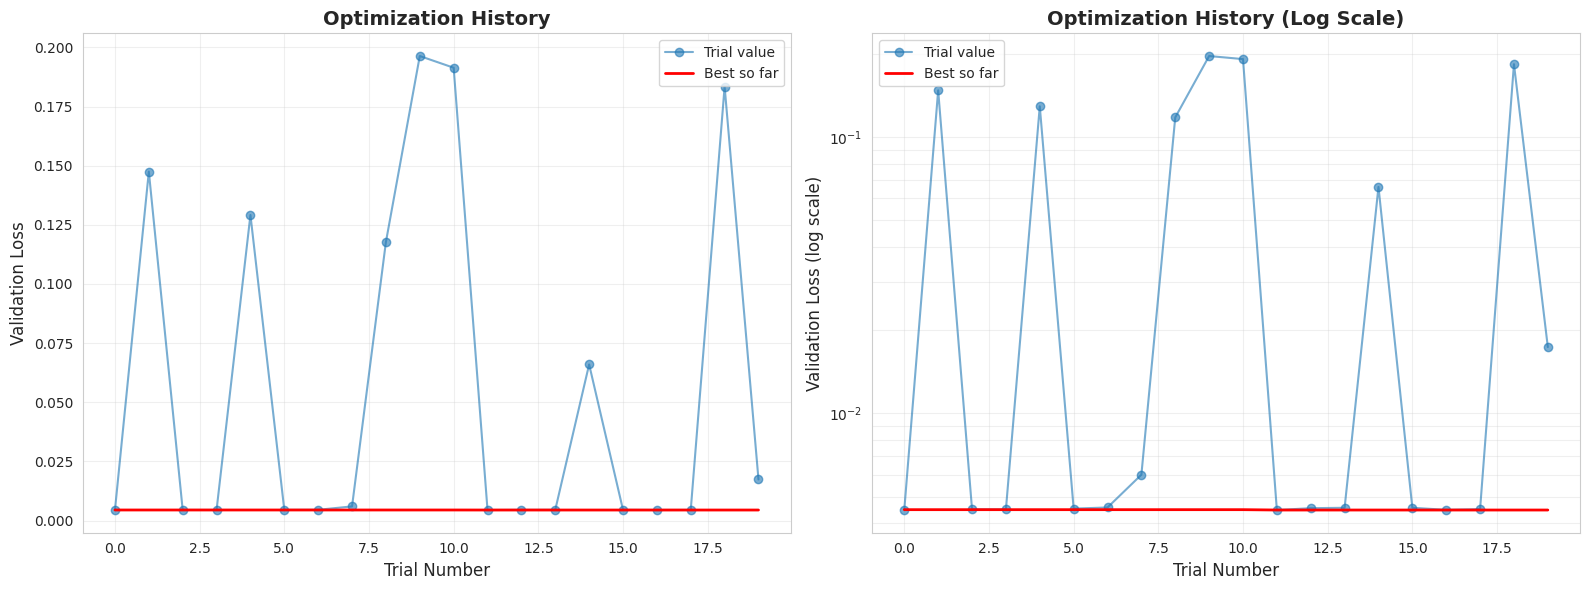

In [3]:
# Plot optimization history
plot_optimization_history(trials_df, save_path=None)

### Parameter Importance

Shows how each hyperparameter correlates with model performance.

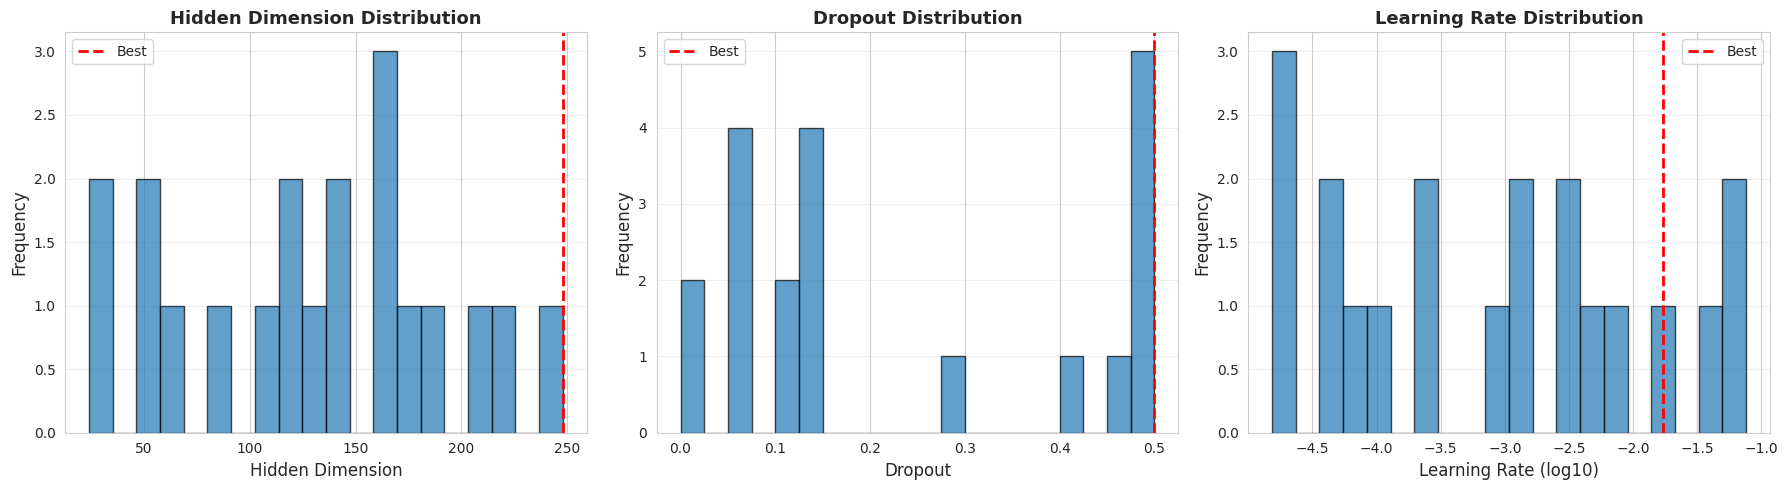

In [4]:
# Plot parameter distributions
plot_parameter_distributions(trials_df, save_path=None)

### Parameter Distributions

Shows the distribution of hyperparameters tried during the sweep.

/data/users/goodarzilab/shervin/182-GNN_SAE/visualize_sweep_results.py:176: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


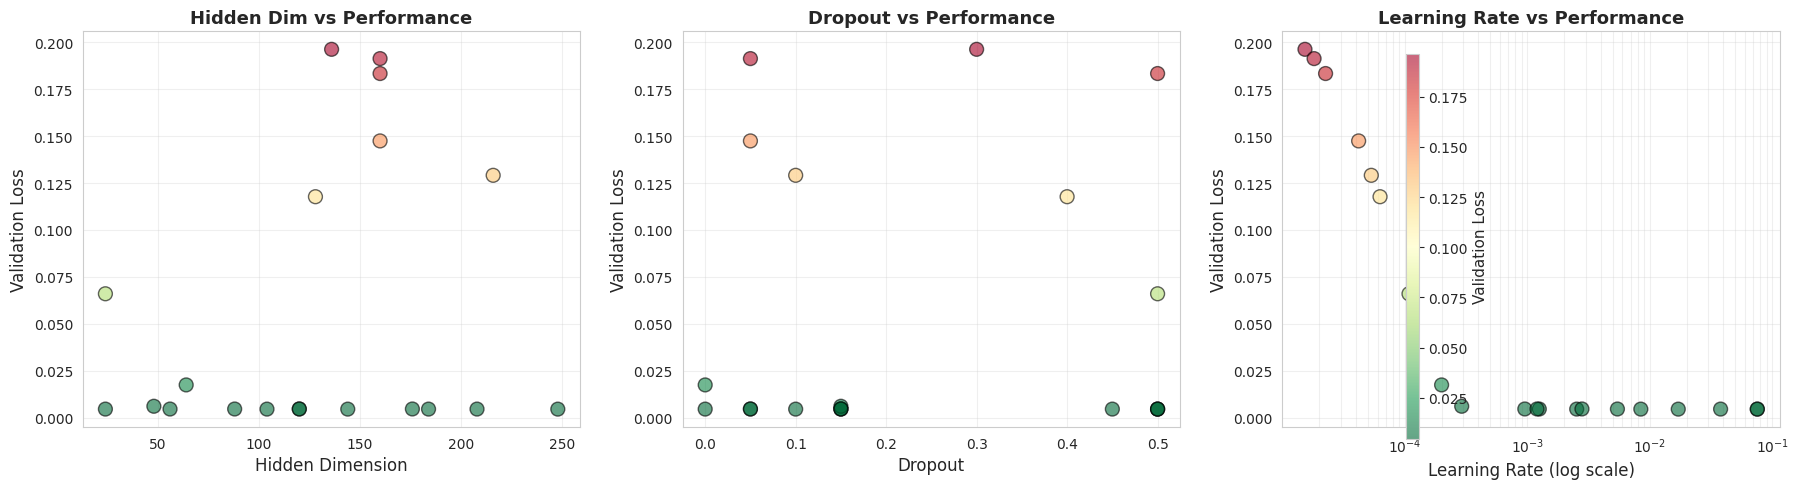

In [5]:
# Plot parameter importance (scatter plots)
plot_parameter_importance(trials_df, save_path=None)

### Optimization History

Shows validation loss over trials and cumulative best loss.

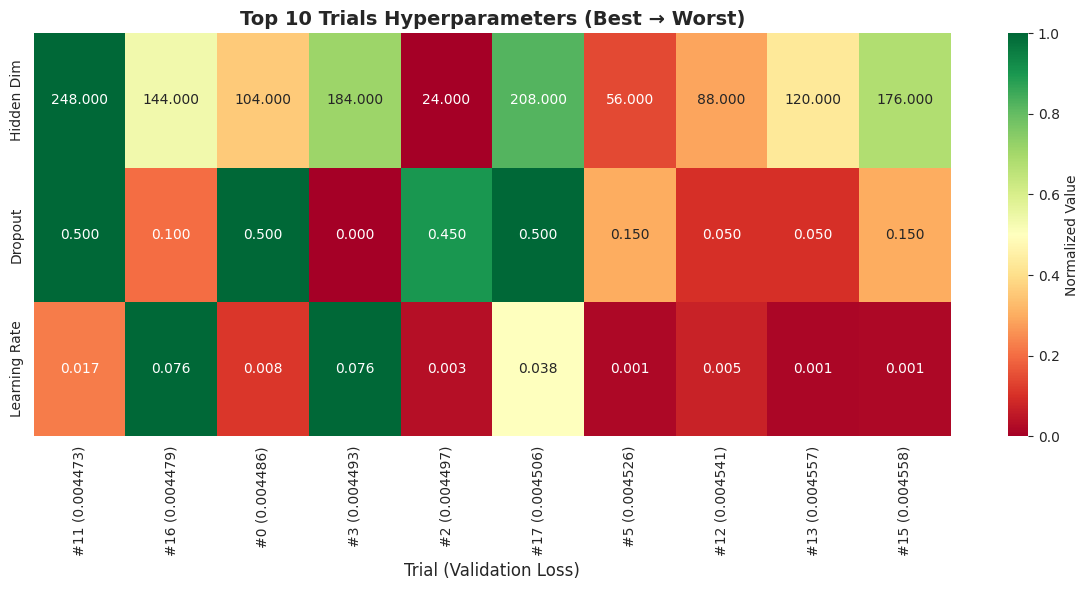

In [6]:
# Plot top 10 trials as heatmap
plot_top_trials(trials_df, top_n=10, save_path=None)

### Summary Statistics